<a href="https://colab.research.google.com/github/Witcape/3D_Printing/blob/main/Final_Results/ALL_PARAMS_SWIN_SRGAN_FINAL_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/AarohiSingla/Swin-Transformer
%cd Swin-Transformer

fatal: destination path 'Swin-Transformer' already exists and is not an empty directory.
/content/Swin-Transformer


In [3]:
!pip install timm
import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
def window_partition(x, patch_size=4):
    """
    Args:
        x: (B, H, W, C)
        patch_size (int): patch size (Default: 4)

    Returns:
        patches: (num_patches * B, patch_size, patch_size, C)
                 (num_windows * B, patch_size, patch_size, C)
    """

    B, H, W, C = x.shape

    # Calculate the number of patches in each dimension
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size

    # Convert to (B, num_patches_h, patch_size, num_patches_w, patch_size, C)
    x = x.view(B, num_patches_h, patch_size, num_patches_w, patch_size, C)

    # Convert to (B, num_patches_h, num_patches_w, patch_size, patch_size, C)
    patches = x.permute(0, 1, 3, 2, 4, 5).contiguous()

    # Efficient Batch Computation - Convert to (B * num_patches_h * num_patches_w, patch_size, patch_size, C)
    patches = patches.view(-1, patch_size, patch_size, C)

    return patches

In [5]:
# Lets use PatchEmbed

class PatchEmbed(nn.Module):
    """ Convert image to patch embedding

    Args:
        img_size (int): Image size (Default: 224)
        patch_size (int): Patch token size (Default: 4)
        in_channels (int): Number of input image channels (Default: 3)
        embed_dim (int): Number of linear projection output channels (Default: 96)
        norm_layer (nn.Module, optional): Normalization layer (Default: None)
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size) # (img_size, img_size) to_2tuple simply convert t to (t,t)
        patch_size = to_2tuple(patch_size) # (patch_size, patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]] # (num_patches, num_patches)

        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        # proj layer: (B, 3, 224, 224) -> (B, 96, 56, 56)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        """
        x: (B, C, H, W) Default: (B, 3, 224, 224)
        returns: (B, H//patch_size * W//patch_size, embed_dim) (B, 56*56, 96)
        """
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}]) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."

        # (B, 3, 224, 224) -> (B, 96, 56, 56)
        x = self.proj(x)

        # (B, 96, 56, 56) -> (B, 96, 56*56)
        x = x.flatten(2)

        # (B, 96, 56*56) -> (B, 56*56, 96): 56 refers to the number of patches
        x = x.transpose(1, 2)

        if self.norm is not None:
            x = self.norm(x)

        return x

In [7]:
# Load the image file
image_path = '/content/test.png'
image = Image.open(image_path)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])

# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

patch_embed = PatchEmbed(img_size=224, patch_size=4, in_chans=3, embed_dim=96)

embedding = patch_embed(tensor_image)


patches = patch_embed(tensor_image)
# Print the shape of the output patches
print("Patches shape:", patches.shape)   # 96 is embedding dimension, 3136 patches 224/4 * 224/4

embedding

Patches shape: torch.Size([1, 3136, 96])


tensor([[[-0.0422, -0.1139, -0.0221,  ..., -0.1269,  0.0427, -0.1057],
         [-0.0424, -0.1139, -0.0260,  ..., -0.1293,  0.0473, -0.1067],
         [-0.0342, -0.1177, -0.0349,  ..., -0.1244,  0.0539, -0.1105],
         ...,
         [-0.1017, -0.1044, -0.1211,  ..., -0.0951,  0.1369, -0.1515],
         [-0.1097, -0.1047, -0.1071,  ..., -0.1000,  0.1250, -0.1405],
         [-0.0966, -0.1057, -0.0533,  ..., -0.1122,  0.0796, -0.1256]]],
       grad_fn=<TransposeBackward0>)

In [8]:
from swin_functions_and_classes import *

stage_1 = BasicLayer(dim=96, input_resolution=(56, 56), depth=2, num_heads=4, window_size=7)

# Pass the patch embeddings through the BasicLayer
output = stage_1(embedding)
print(output.shape)
output

torch.Size([1, 3136, 96])


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[[ 0.9378, -0.0416,  0.4560,  ..., -0.2707, -0.3782,  1.8981],
         [ 0.9377, -0.0447,  0.4515,  ..., -0.2754, -0.3727,  1.8956],
         [ 0.9446, -0.0497,  0.4440,  ..., -0.2691, -0.3720,  1.8877],
         ...,
         [ 0.7990, -0.0364,  0.4519,  ..., -0.3383, -0.2119,  1.8317],
         [ 0.7904, -0.0320,  0.4630,  ..., -0.3457, -0.2151,  1.8555],
         [ 0.7962, -0.0217,  0.5056,  ..., -0.3647, -0.2395,  1.9006]]],
       grad_fn=<AddBackward0>)

In [9]:
# Create an instance of the SwinTransformerBlock class with the desired parameters
block_1 = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=0,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


#  shift_size is set to 3
block_1_shf = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=2,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


# Pass the embedding through the SwinTransformerBlock:
output = block_1(embedding)
output_shf = block_1_shf(embedding)

print(output.shape)
print(output_shf.shape)
print(output)
print(output_shf)

torch.Size([1, 3136, 96])
torch.Size([1, 3136, 96])
tensor([[[-0.3744, -0.3857,  0.1732,  ..., -0.4692,  0.2299, -0.2022],
         [-0.3703, -0.3818,  0.1698,  ..., -0.4717,  0.2378, -0.2015],
         [-0.3530, -0.3807,  0.1655,  ..., -0.4647,  0.2427, -0.2109],
         ...,
         [-0.1879, -0.2720,  0.2105,  ..., -0.3883,  0.5015, -0.3966],
         [-0.2117, -0.2824,  0.2224,  ..., -0.3952,  0.4847, -0.3815],
         [-0.2502, -0.3146,  0.2680,  ..., -0.4217,  0.4267, -0.3560]]],
       grad_fn=<AddBackward0>)
tensor([[[-0.1973,  0.2561, -0.0500,  ...,  0.0782,  0.3806, -0.6107],
         [-0.1997,  0.2571, -0.0490,  ...,  0.0792,  0.3829, -0.6101],
         [-0.0526,  0.1595,  0.1519,  ...,  0.2665,  0.5497, -0.6045],
         ...,
         [-0.0422,  0.1023,  0.2281,  ...,  0.4603,  0.7026, -0.5627],
         [-0.0450,  0.0947,  0.2357,  ...,  0.4538,  0.6964, -0.5599],
         [-0.0164,  0.0781,  0.2714,  ...,  0.4288,  0.6686, -0.5510]]],
       grad_fn=<AddBackward0>)


In [10]:
model = SwinTransformer()

print(tensor_image.shape)

model(tensor_image).shape

torch.Size([1, 3, 224, 224])


torch.Size([1, 1000])

In [11]:
train_dir = '/content/drive/MyDrive/Final_Final/Train'
test_dir = '/content/drive/MyDrive/Final_Final/Test'

In [12]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [13]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [14]:
# Set the batch size
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cfbba4fed70>,
 ['Normal', 'Shaghetti', 'Stringing'])

torch.Size([3, 224, 224]) tensor(2)


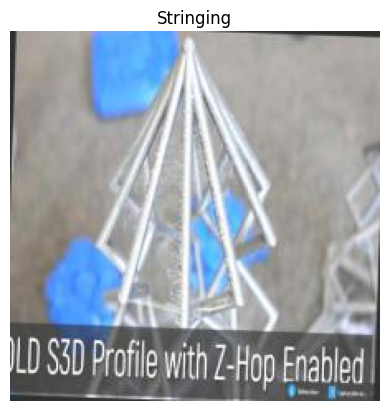

In [15]:
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [16]:
model = SwinTransformer(num_classes=len(class_names))

In [17]:
from going_modular.going_modular import engine
from helper_functions import set_seeds

device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

In [18]:
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0664 | train_acc: 0.3817 | test_loss: 1.3577 | test_acc: 0.3606
Epoch: 2 | train_loss: 1.2110 | train_acc: 0.3571 | test_loss: 1.7210 | test_acc: 0.3990
Epoch: 3 | train_loss: 1.2533 | train_acc: 0.3549 | test_loss: 1.1586 | test_acc: 0.3606
Epoch: 4 | train_loss: 1.1430 | train_acc: 0.3147 | test_loss: 1.0848 | test_acc: 0.3990
Epoch: 5 | train_loss: 1.0981 | train_acc: 0.3683 | test_loss: 1.0984 | test_acc: 0.3990
Epoch: 6 | train_loss: 1.1145 | train_acc: 0.3616 | test_loss: 1.4740 | test_acc: 0.2404
Epoch: 7 | train_loss: 1.1172 | train_acc: 0.3705 | test_loss: 1.2355 | test_acc: 0.3606
Epoch: 8 | train_loss: 1.1252 | train_acc: 0.3404 | test_loss: 1.0903 | test_acc: 0.3990
Epoch: 9 | train_loss: 1.1265 | train_acc: 0.3638 | test_loss: 1.0810 | test_acc: 0.4159
Epoch: 10 | train_loss: 1.0808 | train_acc: 0.4141 | test_loss: 1.1548 | test_acc: 0.3990


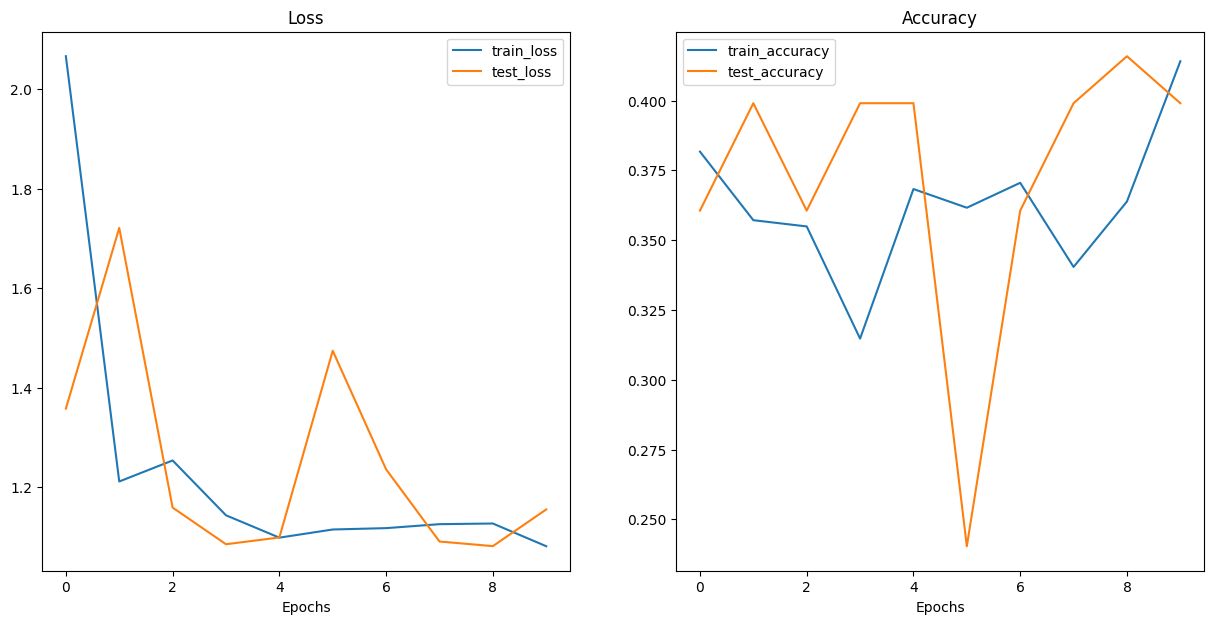

In [19]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

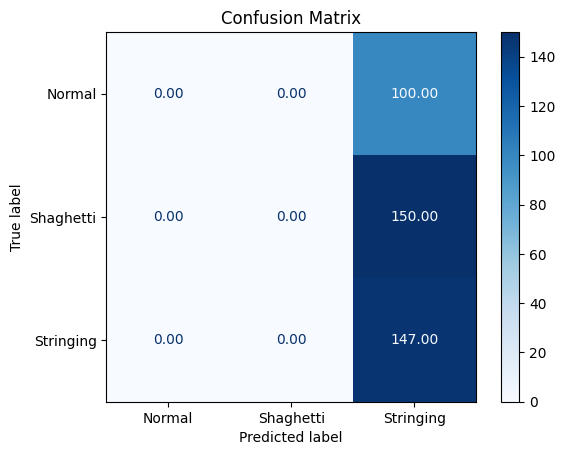

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Function to get all predictions and true labels from the test dataloader
def get_predictions(model, test_dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation for inference
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)  # Move to the appropriate device
            outputs = model(images)  # Get model predictions
            _, preds = torch.max(outputs, 1)  # Get the predicted class indices

            all_preds.extend(preds.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())  # Store true labels

    return np.array(all_labels), np.array(all_preds)

# Get true labels and predictions
true_labels, predictions = get_predictions(model, test_dataloader, device)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues', values_format='.2f')  # You can customize the color map and format
plt.title('Confusion Matrix')
plt.show()

<ipython-input-21-9381fe42351f>:25: RuntimeWarning: invalid value encountered in divide
  specificity_per_class = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)  # Specificity per class
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Overall Accuracy: 37.03%
Overall Sensitivity (Recall): 33.33%
Overall Specificity: nan%
F1 Score (Weighted): 20.01%
Precision (Weighted): 13.71%
Matthews Correlation Coefficient: 0.0000
Cohen's Kappa: 0.0000
37.03%
33.33%
nan%
20.01%
13.71%
0.0000
0.0000


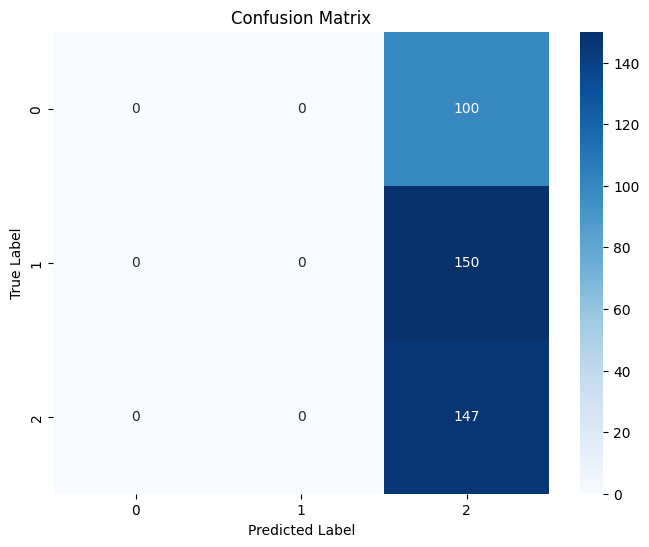

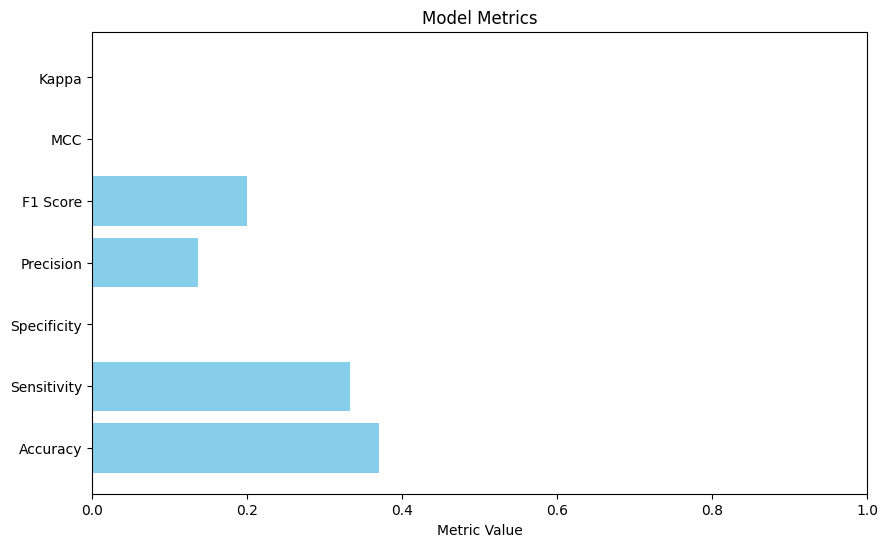

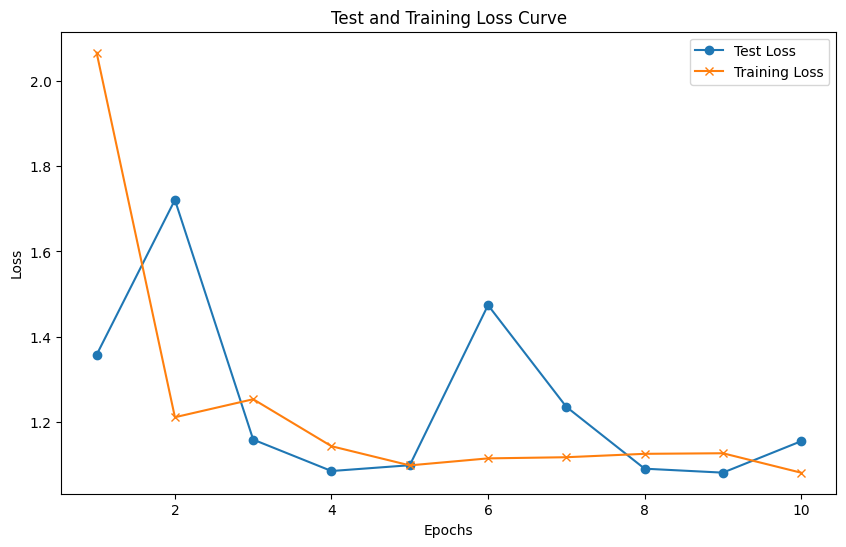

Test Loss: 1.1548138123292189
Training Loss: 1.0808450068746294


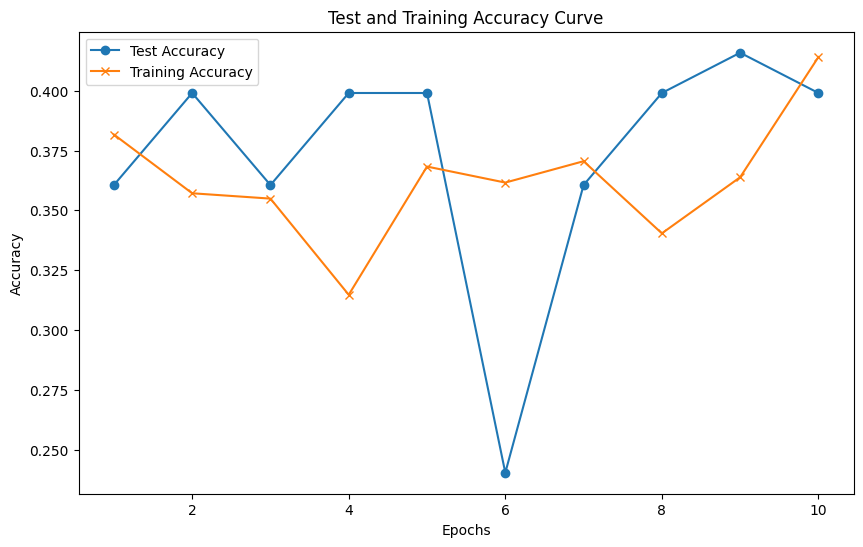

Test Accuracy: 0.39903846153846156
Training Accuracy: 0.4140625


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, f1_score, matthews_corrcoef, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay

# Get predictions and labels
true_labels, predictions = get_predictions(model, test_dataloader, device)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Calculate Accuracy, Sensitivity (Recall), Specificity, Precision, F1 Score, MCC, and Kappa
accuracy = np.trace(conf_matrix) / conf_matrix.sum()  # Overall accuracy
total_TP = np.trace(conf_matrix)  # Total true positives
total_FN = np.sum(conf_matrix, axis=1) - np.trace(conf_matrix)  # Total false negatives
total_FP = np.sum(conf_matrix, axis=0) - np.trace(conf_matrix)  # Total false positives
total_TN = np.sum(conf_matrix) - (total_TP + total_FP + total_FN)  # Total true negatives

sensitivity = total_TP / (total_TP + total_FN)  # Recall
specificity = total_TN / (total_TN + total_FP)  # Specificity

# For multi-class, you may want to calculate these per class and average them
# Sensitivity and Specificity (Per Class)
sensitivity_per_class = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)  # Recall per class
specificity_per_class = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)  # Specificity per class

# Average Sensitivity and Specificity (Macro-average)
average_sensitivity = np.mean(sensitivity_per_class)
average_specificity = np.mean(specificity_per_class)

# Calculate Precision, F1 Score, MCC, Kappa
precision = precision_score(true_labels, predictions, average="weighted")
f1 = f1_score(true_labels, predictions, average="weighted")
mcc = matthews_corrcoef(true_labels, predictions)
kappa = cohen_kappa_score(true_labels, predictions)

# Print final overall values
print(f"Overall Accuracy: {accuracy * 100:.2f}%")
print(f"Overall Sensitivity (Recall): {average_sensitivity * 100:.2f}%")
print(f"Overall Specificity: {average_specificity * 100:.2f}%")
print(f"F1 Score (Weighted): {f1 * 100:.2f}%")
print(f"Precision (Weighted): {precision * 100:.2f}%")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

# To copy easily:
print(f"{accuracy * 100:.2f}%")
print(f"{average_sensitivity * 100:.2f}%")
print(f"{average_specificity * 100:.2f}%")
print(f"{f1 * 100:.2f}%")
print(f"{precision * 100:.2f}%")
print(f"{mcc:.4f}")
print(f"{kappa:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot Metrics
metrics = [accuracy, average_sensitivity, average_specificity, precision, f1, mcc, kappa]
metric_names = ["Accuracy", "Sensitivity", "Specificity", "Precision", "F1 Score", "MCC", "Kappa"]

plt.figure(figsize=(10, 6))
plt.barh(metric_names, metrics, color="skyblue")
plt.xlabel("Metric Value")
plt.title("Model Metrics")
plt.xlim(0, 1)  # Metrics are between 0 and 1
plt.show()

# Assuming the results from the model training (for loss and accuracy curves)
epochs = range(1, len(results['train_loss']) + 1)

# Test Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, results['test_loss'], label='Test Loss', marker='o')
plt.plot(epochs, results['train_loss'], label='Training Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test and Training Loss Curve')
plt.legend()
plt.show()

print("Test Loss:", results['test_loss'][-1])
print("Training Loss:", results['train_loss'][-1])

# Test Accuracy Curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, results['test_acc'], label='Test Accuracy', marker='o')
plt.plot(epochs, results['train_acc'], label='Training Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test and Training Accuracy Curve')
plt.legend()
plt.show()

print("Test Accuracy:", results['test_acc'][-1])
print("Training Accuracy:", results['train_acc'][-1])



In [22]:
# import requests

# # Import function to make predictions on images and plot them
# from going_modular.going_modular.predictions import pred_and_plot_image

# # Setup custom image path
# custom_image_path = "/content/drive/MyDrive/Final_Cropped/Test/Spaghetti/FM637CFIHF6MY36_jpg.rf.e2c23511d4e2fd564d4d7079b1bf28b2.jpg"

# # Predict on custom image
# pred_and_plot_image(model=model,
#                     image_path=custom_image_path,
#                     class_names=class_names)

In [23]:
# import requests

# # Import function to make predictions on images and plot them
# from going_modular.going_modular.predictions import pred_and_plot_image

# # Setup custom image path
# custom_image_path = "/content/drive/MyDrive/Final_Cropped/Test/Stringing/Capture-d-ecran-649-_jpg.rf.2b3ff608b0b53eb78c5f578877320979.jpg"

# # Predict on custom image
# pred_and_plot_image(model=model,
#                     image_path=custom_image_path,
#                     class_names=class_names)